#Imports



In [1]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

#Settings and Dataset

In [2]:
############
###Settings
############

#DEVICE
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Hyperparameters
randomSeed = 123
learningRate = 0.1
numEpochs = 25
batchSize = 256

#Structure
numFeatures = 28*28
numClasses = 10


In [3]:
##
#MNIST
##

trainData = datasets.MNIST(root='data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

testData = datasets.MNIST(root='data',
                          train=False,
                          transform = transforms.ToTensor())

trainLoader = DataLoader(dataset = trainData, batch_size = batchSize, shuffle=True)
testLoader  = DataLoader(dataset = testData , batch_size = batchSize, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 169343578.27it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 100444190.57it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 133982165.07it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19885729.40it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
for images,labels in trainLoader:
  print('Image batch dimensions: ', images.shape)
  print('Label batch dimensions: ', labels.shape)
  break

Image batch dimensions:  torch.Size([256, 1, 28, 28])
Label batch dimensions:  torch.Size([256])


In [5]:
class softmaxRegression(torch.nn.Module):

  def __init__(self,numFeatures,numClasses):
    super(softmaxRegression,self).__init__()
    self.linear = torch.nn.Linear(numFeatures, numClasses)
    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()

  def predict(self,x):
    logits, probas = self.forward(x)
    labels = torch.argmax(probas,dim=1)
    return labels

  def forward(self,x):
    logits = self.linear(x)
    probas = F.softmax(logits,dim=1)
    return logits,probas

  def evaluate(self,x,y):
    pred  = self.predict(x).float()
    acc = torch.sum(pred.view(-1) == y.float()).item() / y.size(0)
    return acc


In [6]:
model = softmaxRegression(numFeatures=numFeatures, numClasses=numClasses)
model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(),lr=learningRate)

In [7]:
torch.manual_seed(randomSeed)

def computeAccuracy(model, dataLoader):
  correctPred = 0
  totalExamples = 0
  for features,targets in dataLoader:
    features = features.view(-1,28*28).to(DEVICE)
    targets = targets.to(DEVICE)
    logits,probas = model(features)
    _,predictedLabels = torch.max(probas,1)
    totalExamples+=targets.size(0)
    correctPred+=(predictedLabels == targets).sum()

  return correctPred.float() / totalExamples * 100

In [8]:
startTime = time.time()
epochCost = []

for e in range(numEpochs):
  avgCost = 0
  for batchIDx, (features,targets) in enumerate(trainLoader):
    features = features.view(-1,28*28).to(DEVICE)
    targets = targets.to(DEVICE)


    logits,probas = model(features)

    cost = F.cross_entropy(logits,targets)
    optimizer.zero_grad()
    cost.backward()
    avgCost += cost

    optimizer.step()
  #
    if(not batchIDx % 50):
      print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' %(e+1,numEpochs, batchIDx, len(trainData)//batchSize, cost) )
  with torch.set_grad_enabled(False):
    avgCost = avgCost/len(trainData)
    epochCost.append(avgCost)
    print('Epoch %03d/%03d training Accuracy: %.2f%%' %(e+1,numEpochs, computeAccuracy(model,trainLoader) ))
    print('Time Elasped: %.2f min' % ((time.time() - startTime)/60))

Epoch: 001/025 | Batch 000/234 | Cost: 2.3026
Epoch: 001/025 | Batch 050/234 | Cost: 0.7693
Epoch: 001/025 | Batch 100/234 | Cost: 0.5321
Epoch: 001/025 | Batch 150/234 | Cost: 0.5617
Epoch: 001/025 | Batch 200/234 | Cost: 0.5501
Epoch 001/025 training Accuracy: 88.05%
Time Elasped: 0.39 min
Epoch: 002/025 | Batch 000/234 | Cost: 0.4793
Epoch: 002/025 | Batch 050/234 | Cost: 0.3686
Epoch: 002/025 | Batch 100/234 | Cost: 0.4535
Epoch: 002/025 | Batch 150/234 | Cost: 0.3731
Epoch: 002/025 | Batch 200/234 | Cost: 0.4791
Epoch 002/025 training Accuracy: 89.26%
Time Elasped: 0.61 min
Epoch: 003/025 | Batch 000/234 | Cost: 0.4057
Epoch: 003/025 | Batch 050/234 | Cost: 0.4456
Epoch: 003/025 | Batch 100/234 | Cost: 0.3770
Epoch: 003/025 | Batch 150/234 | Cost: 0.3893
Epoch: 003/025 | Batch 200/234 | Cost: 0.2996
Epoch 003/025 training Accuracy: 89.94%
Time Elasped: 0.82 min
Epoch: 004/025 | Batch 000/234 | Cost: 0.4298
Epoch: 004/025 | Batch 050/234 | Cost: 0.3918
Epoch: 004/025 | Batch 100/23

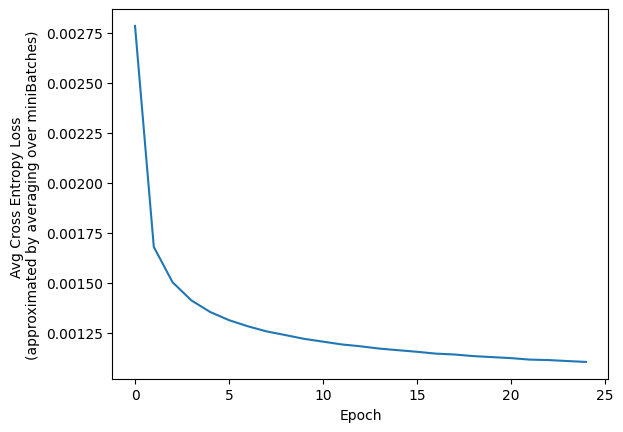

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
EPOCHCOST = []
for i in epochCost:
  EPOCHCOST.append(i.to("cpu"))
plt.plot(EPOCHCOST)
plt.ylabel('Avg Cross Entropy Loss \n(approximated by averaging over miniBatches)')
plt.xlabel('Epoch')
plt.show()


In [13]:
print('Test accuracy: %.2f%%' % (computeAccuracy(model, testLoader)))

Test accuracy: 92.24%


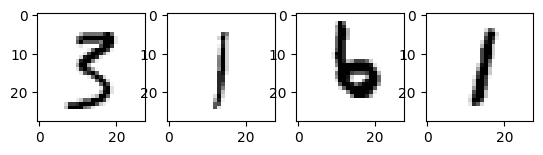

In [14]:
for features, targets in testLoader:
  break
fig, ax = plt.subplots(1,4)
for i in range(4):
  ax[i].imshow(features[i].view(28,28), cmap=matplotlib.cm.binary)

plt.show()

In [18]:
feat = features[:4]

In [20]:
_, predictions = model.forward(feat.view(-1,28*28).to(DEVICE))
predictions = torch.argmax(predictions, dim=1)
print('Predicted Labels', predictions)

Predicted Labels tensor([3, 1, 6, 1], device='cuda:0')
